In [92]:
import collections
from collections import defaultdict
import sys
import json
import random
from jsmin import jsmin
from io import StringIO
import numpy as np
import copy
import importlib
from functools import partial
import math
import os
import argparse
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

script_n = 'pc_grc_pattern_similarity_zscore_211030'

sys.path.insert(0, '/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc')
import my_plot
importlib.reload(my_plot)
from my_plot import MyPlotData

min_length = 30
max_dist = 150

from weight_database import WeightDatabase
weightdb = WeightDatabase()

weightdb.load_syn_db(
    '/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc/gen_db/grc_axons/'
#     'gen_201224_setup01_syndb_threshold_10_coalesced_filtered_10.gz'
    'gen_201224_setup01_syndb_threshold_10_coalesced_filtered_10.gz'
)
weightdb.load_touch_db(
    '/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc/purkinje/'
#     'grc_pc_touches_201224.gz',
    'grc_pc_touches_210429.gz',
    max_dist=max_dist
    )

postsyns = weightdb.get_postsyn_ids()
data_grc = []

def calc_pattern_similarity(weightdb, type='Data'):
    mpd = MyPlotData()
    processed = set()
    n = 0
    pairwise_sim = defaultdict()
    for pc0, pc1 in itertools.combinations(postsyns, 2):
        pair = tuple(sorted((pc0, pc1)))
        if len(weightdb.get_shared_presyns(pair[0], pair[1])) < min_length:
            continue
        score = weightdb.calc_pattern_similarity(pair[0], pair[1])
        pairwise_sim[pair] = score
        n += 1
#     print(f'n={n} pairs')
    return pairwise_sim

mat_data = calc_pattern_similarity(weightdb)

valid_pcs = set()
for pc0 in postsyns:
    for pc1 in postsyns:
        pair = tuple(sorted((pc0, pc1)))
        if pc0 == pc1: continue
        if pair in mat_data:
            valid_pcs.add(pc0)
valid_pcs.remove('purkinje_0.dendrite_20')
valid_pcs = list(valid_pcs)

weightdb_random = weightdb.randomize_connectivity(type='postsyn')
mat_random = calc_pattern_similarity(weightdb_random, type='Random')


In [93]:
print(len(valid_pcs))
print(valid_pcs)

31
['pc_57', 'pc_2', 'pc_19', 'pc_53', 'pc_26', 'pc_1', 'pc_0', 'pc_7', 'pc_50', 'purkinje_1', 'pc_18', 'pc_16', 'pc_4', 'pc_17', 'pc_32', 'pc_22', 'pc_20', 'pc_21', 'pc_31', 'purkinje_0', 'pc_10', 'pc_43', 'pc_28', 'pc_23', 'pc_25', 'pc_9', 'pc_15', 'pc_48', 'pc_5', 'pc_51', 'pc_3']


In [77]:

n_random = 1000
rounds = []
for n in range(n_random):
    print('', end='.')
    weightdb_random = weightdb.randomize_connectivity(type='postsyn')
    mat_random = calc_pattern_similarity(weightdb_random, type='Random')
    rounds.append(mat_random)


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [78]:
import compress_pickle
fname = f'{script_n}_gen_{n_random}.gz'
print(fname)
compress_pickle.dump(rounds, fname)

pc_grc_pattern_similarity_zscore_211030_gen_1000.gz


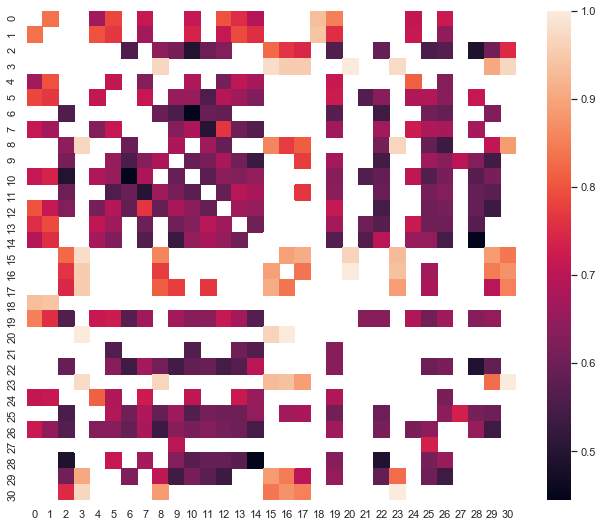

In [61]:
data_mat = []
mask = []
for i in valid_pcs:
    row = []
    mask_row = []
    for j in valid_pcs:
        p = tuple(sorted((i, j)))
        if p in mat_data:
            row.append(mat_data[p])
            mask_row.append(0.)
        else:
            row.append(.5)
            mask_row.append(1.)
    data_mat.append(row)
    mask.append(mask_row)

mask = np.array(mask)
sns.set_theme(style="white")
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(data_mat,
#             center=0,
#             vmax=3,
            square=True,
            mask=mask,
           )

In [95]:
random_datas = compress_pickle.load('pc_grc_pattern_similarity_zscore_211030_gen_1000.gz')
# calculate means and std
random_data_list = defaultdict(list)
for rand_data in random_datas:
    for pair in itertools.combinations(valid_pcs, 2):
        pair = tuple(sorted(pair))
        if pair in rand_data:
            random_data_list[pair].append(rand_data[pair])

import statistics
random_means_mat = []
random_std_mat = []
z_mat = []
z_scores = {}
for i in valid_pcs:
    mean_row = []
    std_row = []
    row = []
    for j in valid_pcs:
        pair = tuple(sorted((i, j)))
        if i == j or pair not in mat_data:
            mean_row.append(0)
            std_row.append(0)
            row.append(-10)
            continue
        l = random_data_list[tuple(sorted((i, j)))]
        d = mat_data[tuple(sorted((i, j)))]
        mean, std = statistics.mean(l), statistics.stdev(l)
        mean_row.append(mean)
        std_row.append(std)
#         if mean == 0 and d == 0:
#             row.append(0)
#             continue
#         elif mean == 0 and std == 0:
#             std = 0.01
#             val = min((d-mean)/std, 3)
#             row.append(val)
#             continue
        row.append((d-mean)/std)
        z_scores[pair] = (d-mean)/std
    random_means_mat.append(mean_row)
    random_std_mat.append(std_row)
    z_mat.append(row)

In [96]:
# save zscore matrix, mask, and data
fname = f'{script_n}_data.gz'
print(fname)
compress_pickle.dump((z_mat, mask, mat_data, valid_pcs, z_scores), fname)

pc_grc_pattern_similarity_zscore_211030_data.gz


TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'

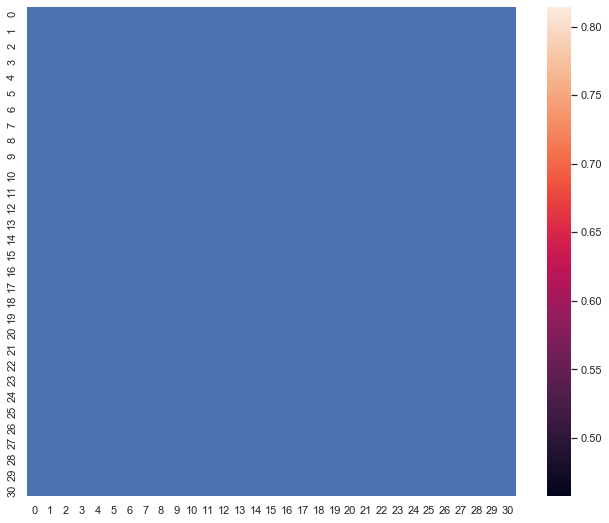

In [85]:
sns.set_theme(style="white")
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(random_means_mat,
#             cmap=cmap,
#             vmin=0,
#             vmax=3,
#             center=0,
#             vmax=0,
#             center=0,
            square=True,
#             linewidths=.5, cbar_kws={"shrink": .5}
            mask=mask,
           )

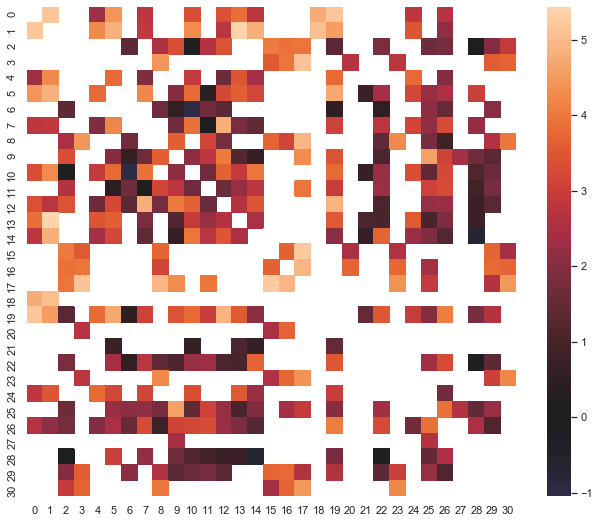

In [90]:
sns.set_theme(style="white")
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(z_mat,
#             cmap=cmap,
#             vmin=0,
#             vmax=3,
            center=0,
#             vmax=0,
#             center=0,
            square=True,
#             linewidths=.5, cbar_kws={"shrink": .5}
            mask=mask,
           )